In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random
import BayesOpt
import Benoit_Problem

# 0. Benoit's Problem

In [ ]:
Benoit_System_noiseless_1 = Benoit_Problem.Benoit_System_noiseless_1
Benoit_System_1 = Benoit_Problem.Benoit_System_1

con1_system_noiseless = Benoit_Problem.con1_system_noiseless
con1_system = Benoit_Problem.con1_system

con1_system_tight = Benoit_Problem.con1_system_tight
con1_system_tight_noiseless = Benoit_Problem.con1_system_tight_noiseless


real optimal input: [-4.97322951e-09 -4.97201070e-09]
real optimal input: [ 0.36845785 -0.39299271]


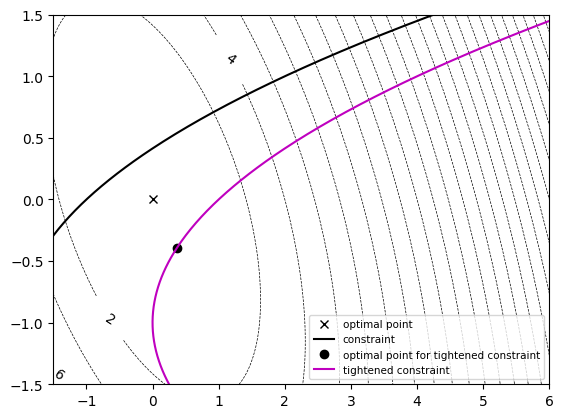

In [3]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-6.5, 6.5, delta)
        y = np.arange(-6.5, 6.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,50,26)

        CS1 = plt.contour(u[0],u[1],Benoit_System_noiseless_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1.5, 6.0, -1.5, 1.5))

        if is_constraint == True:
                # Plot for optimal value for optimization with constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_noiseless(u)}) 
                result = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})
                
                ustar = result.x
                print(f"real optimal input: {ustar}")
                fstar = result.fun
                plt.plot(ustar[0],ustar[1],'kx')
                
                # Plot for constraint
                uc0 = 1. + x ** 2 + 2. * x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:

                # Plot for optimal value for optimization with tightened constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_tight_noiseless(u)}) 
                result_tight = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})

                ustar = result_tight.x
                print(f"real optimal input: {ustar}")
                fstar = result_tight.fun
                plt.plot(ustar[0],ustar[1],'ko')

                # Plot for tightened constraint

                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()

# 1. Bayesian Optimization with Trust Region 

In [4]:
# Source: ML4ChemEng_DataDrivenOpt.ipynb from Dr Antonio Del Rio Chanona
def Ball_sampling(ndim, r_i):
    '''
    This function samples randomly within a ball of radius r_i
    '''
    u      = np.random.normal(0,1,ndim)  # random sampling in a ball
    norm   = np.sum(u**2)**(0.5)
    r      = random.random()**(1.0/ndim)
    d_init = r*u/norm*r_i*2      # random sampling in a ball

    return d_init

# Plant Model 
def Benoit_Model_nomodifier(u,theta):
    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2
    return f

def con1_model_nomodifier(u,theta):
    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 
    return -g1

# Plant Model 
def Benoit_Model_nomodifier_1(theta,u):
    '''
    Benoit Model without modifier but parameter 'theta' is 
    in front for scipy minimize function based on theta
    '''
    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2
    return f

def con1_model_nomodifier_1(theta,u):
    '''
    Benoit Model without modifier but parameter 'theta' is 
    in front for scipy minimize function based on theta
    '''
    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 
    return -g1

# Weight Least Square for Benoit Model without any modifier
def WLS_nomodifier(theta,U,plant_func,plant_constraint):
    '''
    This function finds the sum of weight least square between 
    plant and model function and constraints without modifiers
    '''
    n_s = U.shape[0]
    error = 0

    for i in range(n_s):
        error += (Benoit_Model_nomodifier_1(theta,U[i,:]) - plant_func(U[i]))**2/np.abs(plant_func(U[i]))
        error += (con1_model_nomodifier_1(theta,U[i,:]) - plant_constraint(U[i]))**2/np.abs(plant_constraint(U[i]))

    return error

def parameter_estimation_nomodifier(U,theta_0,plant_func,plant_constraint):
    '''
    U: matrix: [x^(1),...,x^(n_d)]
    plant_func: vecor:  [f(x^(1)),...,f(x^(n_d))]

    This function estimates parameters of the model using sample U,Y
    '''
    # minimizing benoit's model and constraint with scipy minimize
    res         = minimize(WLS_nomodifier, args=(U,plant_func,plant_constraint), x0=theta_0, method='COBYLA')
    # obtaining solution
    params      = res.x
    #f_val  = res.fun

    return params

def GP_Initilization(n_s,u_0,theta_0,r,plant_fun,plant_con1):

    # === first sampling inside the radius === #
    u_dim                           = np.shape(u_0)[0]                          # dimension for input
    u_sample                        = np.zeros((n_s,u_dim))
    modifier_sample                 = np.zeros((n_s,2))          # sample for plant output and constraint output

    # === Collect Training Dataset (Input) === #
    for sample_i in range(n_s):                       
        u_trial                     = u_0 + Ball_sampling(u_dim, r)
        u_sample[sample_i]          = u_trial

    # === Estimate the parameters === #
    theta_0                         = parameter_estimation_nomodifier(u_sample,theta_0,plant_fun,plant_con1)

    # === Collect Training Datase (Modifiers: Plant output and constraint output differences) === #
    for sample_i in range(n_s):
        f_modifier                  = plant_fun(u_sample[sample_i]) - Benoit_Model_nomodifier(u_sample[sample_i],theta_0)
        c_modifier                  = (plant_con1(u_sample[sample_i]) - con1_model_nomodifier(u_sample[sample_i],theta_0))*(-1)
        modifier_sample[sample_i]   = [f_modifier,c_modifier]

    # === Initialize GP with modifier === #
    GP_m                            = BayesOpt.BayesianOpt(u_sample, modifier_sample, 'RBF', multi_hyper=1, var_out=True)
    modifier_infer                  = GP_m.GP_inference_np(u_0)
    modifier_infer_m                = modifier_infer[0]
    modifier_infer_var              = modifier_infer[1]

    return theta_0,modifier_infer_m,GP_m

## B. Cost Function Optimization and Trust Region Update

In [5]:
###########################################################
# --- Benoit's Model w.r.t distance and Gassian Model --- #
###########################################################
def Benoit_Model_d_withGP(d,u0,theta,GP_m):
    modifier_infer      = GP_m.GP_inference_np(u0+d)
    g0_m                = modifier_infer[0][0]
    g0_var              = modifier_infer[1][0]
    f                   = theta[0] * (u0[0]+d[0]) ** 2 + theta[1] * (u0[1]+d[1]) ** 2 + g0_m
    return f

def con1_model_d_withGP(d,u0,theta,GP_m):
    modifier_infer      = GP_m.GP_inference_np(u0+d)
    g1_m                = modifier_infer[0][1]
    g1_var              = modifier_infer[1][1]
    g1                  = 1. - theta[2]*(u0[0]+d[0]) + theta[3]*(u0[1]+d[1]) ** 2 + g1_m
    return -g1

#############################
# --- cost optimization --- #
#############################
def cost_optimize_d_withGP(r,u0,theta,GP_m):
    '''
    Added additional constraint that the distance d
    should be within a circle with radius r
    '''
    d0 = [0,0]

    con = ({'type': 'ineq',
            'fun': lambda d: con1_model_d_withGP(d,u0,theta,GP_m)})
    
    con_circle = ({'type': 'ineq',
            'fun': lambda d: r - np.linalg.norm(d)})
    
    result = minimize((Benoit_Model_d_withGP),
                    d0,
                    constraints =(con, con_circle),
                    method      ='SLSQP',
                    bounds      = ((-r,r),(-r,r)),
                    options     = {'ftol': 1e-9},
                    args        = (u0,theta,GP_m))
    
    return result.x,result.fun

def trust_region_update(uk,uk_1,funk,funk_1,plant_fun,plant_con1,r,r_red,r_inc):
    # if current min is bigger than previous min
    if plant_fun(uk) < plant_fun(uk_1):
        return uk_1,funk_1, r*r_red
    elif plant_con1(uk_1) < 0:
        return uk_1,funk_1, r*r_red
    else:
        pass
    
    # Calculate merit function
    rho = (plant_fun(uk) - plant_fun(uk_1))/(funk-funk_1)
    # if model is good enough
    if rho > 0.8:
        if r > 1:
            return uk_1,funk_1,r
        else:
            return uk_1,funk_1,r*r_inc
    elif rho < 0.2:
        return uk_1,funk_1, r*r_red
    else:
        return uk_1,funk_1, r

## C. Overall Algorithm

### I. Plant without Uncertainty

In [6]:
n_s                 = 5                            # number of samples
n_t                 = 5                             # number of trials
n_i                 = 40                            # number of iterations
plant_fun           = Benoit_System_noiseless_1
plant_con1          = con1_system_tight_noiseless

data = {}
data['index']       = []
data['u_0']         = []
data['u_1']         = []
data['r']           = []
data['modifiers']   = []

# Algorithm
for i in range(n_t):
    # Initialization
    uk                  = [4,-1]
    theta_0             = [1,1,1,1]
    r                   = 0.2
    theta,modifierk,GP_m     = GP_Initilization(n_s,uk,theta_0,r,plant_fun,plant_con1)
    print(theta)

    # Dictionary for data collection at the last iter
    if i == (n_t-1):
        data['index']       = [0]
        data['u_0']         = [uk[0]]
        data['u_1']         = [uk[1]]
        data['r']           = [r]
        data['modifiers']   = [[modifierk]]

    # (j=0)
    funk = plant_fun(uk)
    fun_mk = Benoit_Model_nomodifier(uk,theta)
    cost    = [funk]

    for j in range(n_i):
        dk_1,fun_mk_1                           = cost_optimize_d_withGP(r,uk,theta,GP_m)                                            # Find optimal step and output from the model 
        uk_1                                    = uk + dk_1                                                                     # Find optimal input
        uk_1,fun_mk_1,r                         = trust_region_update(uk,uk_1,fun_mk,fun_mk_1,plant_fun,plant_con1,r,0.8,1.2)         # Trust Region Update
        
        # Modifier 
        f_modifier                              = plant_fun(uk_1) - Benoit_Model_nomodifier(uk_1,theta)
        c_modifier                              = (plant_con1(uk_1) - con1_model_nomodifier(uk_1,theta))*(-1)
        modifierk_1                             = [f_modifier,c_modifier]
        GP_m.add_sample(uk_1,modifierk_1)
        
        # Update variables for next iteration
        uk = uk_1
        fun_mk = fun_mk_1
    
        # Data Collection
        ## New cost
        funk_1                                  = plant_fun(uk_1)
        cost.append(funk_1)

        # Data Collection for graphical illustration at the last iteration 
        if i == (n_t-1):
            data['index'].append(j+1)
            data['u_0'].append(uk_1[0])
            data['u_1'].append(uk_1[1])
            data['r'].append(r)
            ## New modifiers
            modifier_infer                          = GP_m.GP_inference_np(uk_1)
            modifierk_1                             = [modifier_infer[0]]
            data['modifiers'].append([modifierk_1])
        
    
    data[f"Cost Trial {i}"] = cost

        
    print(f"optimal input: {uk}")


[0.82124268 0.10104483 1.25412994 0.10632645]


/Users/donggyulee/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


optimal input: [ 0.37814602 -0.3977628 ]
[0.79374884 0.53506091 1.27959328 0.14802585]
optimal input: [ 1.13788832 -0.58579771]
[0.80437033 0.31104402 1.30788673 0.27386702]
optimal input: [ 0.41230322 -0.41937275]
[0.76879448 0.3313756  1.54087626 0.8914867 ]
optimal input: [ 0.32193269 -0.45458287]
[ 0.82361541 -0.09439279  1.25956581  0.10951096]
optimal input: [ 0.44820054 -1.20020452]


### II. Graphical Illustration

real optimal input: [ 0.36845785 -0.39299271]


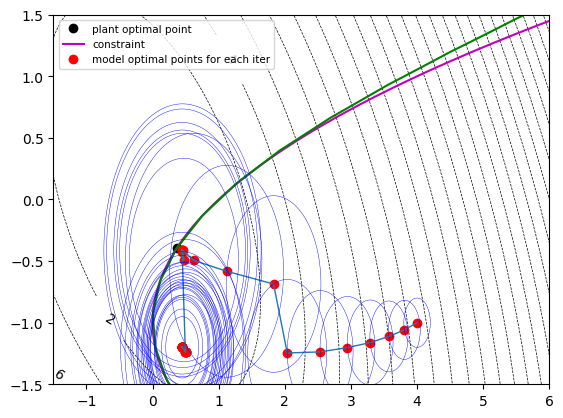

In [7]:
num_points = 100

plant_drawing(is_constraint=False,is_tight_constraint=True)

plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')

uc_0 = np.linspace(-6.5,6.5,50)
uc_1 = np.linspace(-6.5,6.5,50)
UC_0,UC_1 = np.meshgrid(uc_0,uc_1)
F_C = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        U = [UC_0[i][j],UC_1[i][j]]
        d = np.array([0,0])
        F_C[i][j] = -con1_model_d_withGP(d,U,theta,GP_m)
plt.contour(UC_0,UC_1,F_C,[0],colors='g')

i = 0
for i in range(data['index'][-1]+1):
    centerx,centery = data['u_0'][i],data['u_1'][i]
    r = data['r'][i]

    x = np.linspace(centerx-r, centerx+r, 50)
    y = np.linspace(centery-r, centery+r, 50)
    X, Y = np.meshgrid(x,y)
    F = (X-centerx)**2 + (Y-centery)**2 - r**2
    plt.contour(X,Y,F,[0],colors='b',linewidths = 0.3)

plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

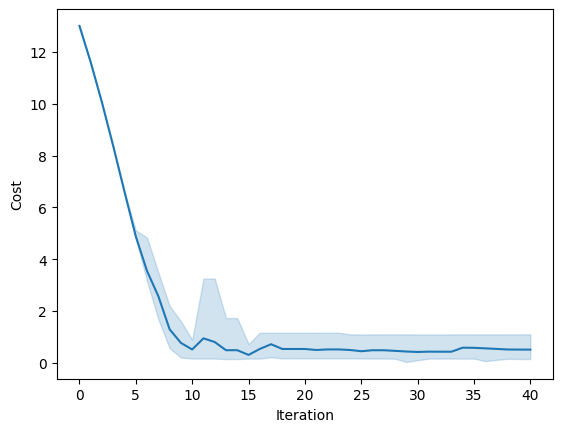

In [8]:
cost_stat = {}
cost_stat["mean"] = []
cost_stat['max'] = []
cost_stat['min'] = []

for iteration in range(n_i+1):
    iteration_data = [data[f"Cost Trial {i}"][iteration] for i in range(n_t)]

    mean_val = np.mean(iteration_data)
    max_val = np.max(iteration_data)
    min_val = np.min(iteration_data)

    cost_stat['mean'].append(mean_val)
    cost_stat['max'].append(max_val)
    cost_stat['min'].append(min_val)

plt.plot(data['index'],cost_stat['mean'])

plt.gca().fill_between(data['index'],cost_stat['min'],cost_stat['max'],color='C0', alpha=0.2)

plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()


### II. Plant with Uncertainty

#### RTO Algorithm

In [295]:
n_s                 = 5                            # number of samples
n_t                 = 5                             # number of trials
n_i                 = 40                            # number of iterations
plant_fun           = Benoit_System_1
plant_con1          = con1_system_tight

data = {}
data['index']       = []
data['u_0']         = []
data['u_1']         = []
data['r']           = []
data['modifiers']   = []

# Algorithm
for i in range(n_t):
    # Initialization
    uk                  = [4,-1]
    theta_0             = [1,1,1,1]
    r                   = 0.2
    theta,modifierk,GP_m     = GP_Initilization(n_s,uk,theta_0,r,plant_fun,plant_con1)
    print(theta)

    # Dictionary for data collection at the last iter
    if i == (n_t-1):
        data['index']       = [0]
        data['u_0']         = [uk[0]]
        data['u_1']         = [uk[1]]
        data['r']           = [r]
        data['modifiers']   = [[modifierk]]

    # (k=0)
    funk = plant_fun(uk)
    fun_mk = Benoit_Model_nomodifier(uk,theta)
    cost    = [funk]

    for j in range(n_i):
        dk_1,fun_mk_1                           = cost_optimize_d_withGP(r,uk,theta,GP_m)                                            # Find optimal step and output from the model 
        uk_1                                    = uk + dk_1                                                                     # Find optimal input
        uk_1,fun_mk_1,r                         = trust_region_update(uk,uk_1,fun_mk,fun_mk_1,plant_fun,plant_con1,r,0.8,1.2)         # Trust Region Update

        # Modifier 
        f_modifier                              = plant_fun(uk_1) - Benoit_Model_nomodifier(uk_1,theta)
        c_modifier                              = (plant_con1(uk_1) - con1_model_nomodifier(uk_1,theta))*(-1)
        modifierk_1                             = [f_modifier,c_modifier]
        GP_m.add_sample(uk_1,modifierk_1)
        
        # Update variables for next iteration
        uk = uk_1
        fun_mk = fun_mk_1
    
        # Data Collection
        ## New cost
        funk_1                                  = plant_fun(uk_1)
        cost.append(funk_1)

        # Data Collection for graphical illustration at the last iteration 
        if i == (n_t-1):
            data['index'].append(j+1)
            data['u_0'].append(uk_1[0])
            data['u_1'].append(uk_1[1])
            data['r'].append(r)
            ## New modifiers
            modifier_infer                          = GP_m.GP_inference_np(uk_1)
            modifierk_1                             = [modifier_infer[0]]
            data['modifiers'].append([modifierk_1])
    
    data[f"Cost Trial {i}"] = cost

        
    print(f"optimal input: {uk}")


[0.74930574 0.77147874 1.87732821 2.08254306]
optimal input: [ 0.37216851 -0.38942925]
[0.7405203  0.71816468 1.90298392 2.00705416]
optimal input: [ 0.37072947 -0.38763314]
[0.76552664 1.24125268 1.46580613 1.07456126]
optimal input: [ 0.3485348  -0.40263189]
[0.73406825 0.73201457 1.94153637 2.06792203]
optimal input: [ 0.41911982 -0.35526912]
[0.73339162 0.72090445 1.91908617 2.07409795]
optimal input: [ 0.48445574 -0.30539352]


real optimal input: [ 0.36845785 -0.39299271]


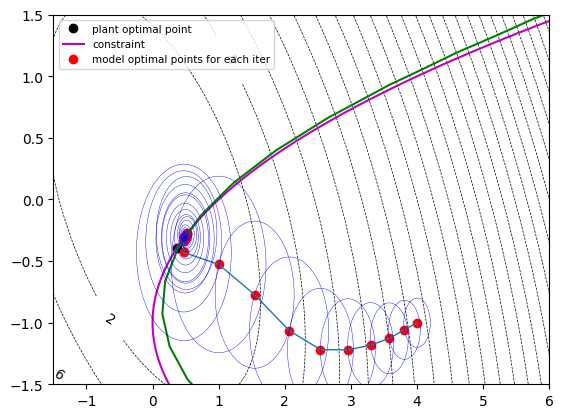

In [296]:
num_points = 100

plant_drawing(is_constraint=False,is_tight_constraint=True)

plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')

uc_0 = np.linspace(-6.5,6.5,50)
uc_1 = np.linspace(-6.5,6.5,50)
UC_0,UC_1 = np.meshgrid(uc_0,uc_1)
F_C = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        U = [UC_0[i][j],UC_1[i][j]]
        d = np.array([0,0])
        F_C[i][j] = con1_model_d_withGP(d,U,theta,GP_m)
plt.contour(UC_0,UC_1,F_C,[0],colors='g')

i = 0
for i in range(data['index'][-1]+1):
    centerx,centery = data['u_0'][i],data['u_1'][i]
    r = data['r'][i]

    x = np.linspace(centerx-r, centerx+r, 50)
    y = np.linspace(centery-r, centery+r, 50)
    X, Y = np.meshgrid(x,y)
    F = (X-centerx)**2 + (Y-centery)**2 - r**2
    plt.contour(X,Y,F,[0],colors='b',linewidths = 0.3)

plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

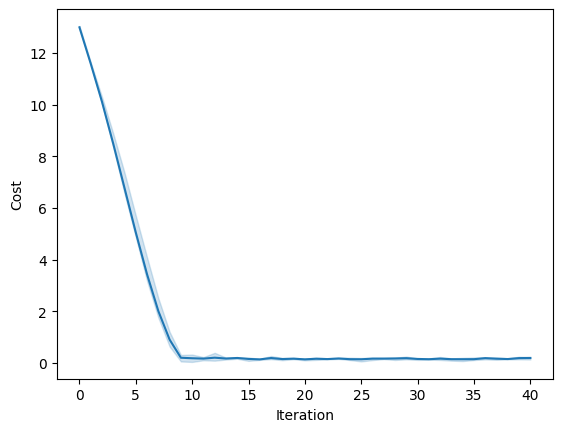

In [297]:
cost_stat = {}
cost_stat["mean"] = []
cost_stat['max'] = []
cost_stat['min'] = []

for iteration in range(n_i+1):
    iteration_data = [data[f"Cost Trial {i}"][iteration] for i in range(n_t)]

    mean_val = np.mean(iteration_data)
    max_val = np.max(iteration_data)
    min_val = np.min(iteration_data)

    cost_stat['mean'].append(mean_val)
    cost_stat['max'].append(max_val)
    cost_stat['min'].append(min_val)

plt.plot(data['index'],cost_stat['mean'])

plt.gca().fill_between(data['index'],cost_stat['min'],cost_stat['max'],color='C0', alpha=0.2)

plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()


# 2. Bayesian Optimization with Trust Region as variance

In [298]:
def GP_var(d,u0,GP_m):
     modifier_infer      = GP_m.GP_inference_np(u0+d)
     g0_var              = modifier_infer[1][0]

     return g0_var

def cost_optimize_d_withGP(r,u0,theta,GP_m):
    '''
    Added additional constraint that the distance d
    should be within a circle with radius r
    '''
    d0 = [0,0]

    con = ({'type': 'ineq',
            'fun': lambda d: con1_model_d_withGP(d,u0,theta,GP_m)})
    
    con_var = ({'type': 'ineq',
            'fun': lambda d: 0.5 - GP_var(d,u0,GP_m)})
    
    result = minimize((Benoit_Model_d_withGP),
                    d0,
                    constraints =(con,con_var),
                    method      ='SLSQP',
                    bounds      = ((-r,r),(-r,r)),
                    options     = {'ftol': 1e-9},
                    args        = (u0,theta,GP_m))
    
    return result.x,result.fun

### I. Plant without uncertainty

In [299]:
n_s                 = 5                            # number of samples
n_t                 = 5                             # number of trials
n_i                 = 40                            # number of iterations
plant_fun           = Benoit_System_noiseless_1
plant_con1          = con1_system_tight_noiseless

data = {}
data['index']       = []
data['u_0']         = []
data['u_1']         = []
data['r']           = []
data['modifiers']   = []

# Algorithm
for i in range(n_t):
    # Initialization
    uk                  = [4,-1]
    theta_0             = [1,1,1,1]
    r                   = 0.2
    theta,modifierk,GP_m     = GP_Initilization(n_s,uk,theta_0,r,plant_fun,plant_con1)
    print(theta)

    # Dictionary for data collection at the last iter
    if i == (n_t-1):
        data['index']       = [0]
        data['u_0']         = [uk[0]]
        data['u_1']         = [uk[1]]
        data['r']           = [r]
        data['modifiers']   = [[modifierk]]

    # (k=0)
    funk = plant_fun(uk)
    fun_mk = Benoit_Model_nomodifier(uk,theta)
    cost    = [funk]

    for j in range(n_i):
        dk_1,fun_mk_1                           = cost_optimize_d_withGP(r,uk,theta,GP_m)                                            # Find optimal step and output from the model 
        uk_1                                    = uk + dk_1                                                                     # Find optimal input

        # Modifier 
        f_modifier                              = plant_fun(uk_1) - Benoit_Model_nomodifier(uk_1,theta)
        c_modifier                              = (plant_con1(uk_1) - con1_model_nomodifier(uk_1,theta))*(-1)
        modifierk_1                             = [f_modifier,c_modifier]
        GP_m.add_sample(uk_1,modifierk_1)
        
        # Update variables for next iteration
        uk = uk_1
        fun_mk = fun_mk_1
    
        # Data Collection
        ## New cost
        funk_1                                  = plant_fun(uk_1)
        cost.append(funk_1)

        # Data Collection for graphical illustration at the last iteration 
        if i == (n_t-1):
            data['index'].append(j+1)
            data['u_0'].append(uk_1[0])
            data['u_1'].append(uk_1[1])
            data['r'].append(r)
    
    data[f"Cost Trial {i}"] = cost

        
    print(f"optimal input: {uk}")

[0.7728537  0.853734   1.41009166 0.74583303]
optimal input: [ 0.5013838  -0.50652586]
[0.78893317 0.1688447  1.45923979 0.69120782]
optimal input: [ 0.86796936 -0.85348426]
[0.81149627 0.12187946 1.27643012 0.14590082]
optimal input: [ 0.97965031 -0.56122493]
[0.83248619 0.12086328 1.25256004 0.13767826]
optimal input: [ 1.1294068  -0.44420677]
[0.7840651  0.37968701 1.55121559 1.11935635]
optimal input: [ 0.68520815 -0.19060503]


real optimal input: [ 0.36845785 -0.39299271]


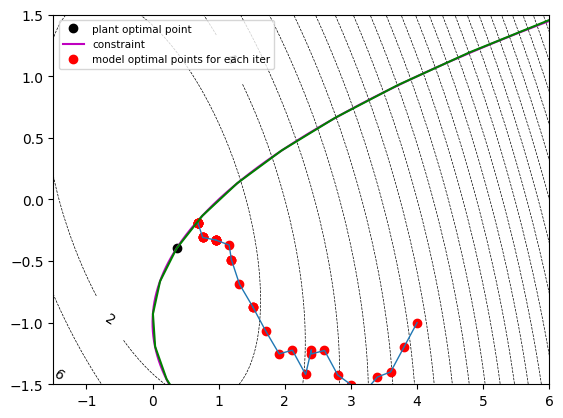

In [300]:
num_points = 100

plant_drawing(is_constraint=False,is_tight_constraint=True)

plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')

uc_0 = np.linspace(-6.5,6.5,50)
uc_1 = np.linspace(-6.5,6.5,50)
UC_0,UC_1 = np.meshgrid(uc_0,uc_1)
F_C = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        U = [UC_0[i][j],UC_1[i][j]]
        d = np.array([0,0])
        F_C[i][j] = con1_model_d_withGP(d,U,theta,GP_m)
plt.contour(UC_0,UC_1,F_C,[0],colors='g')

# i = 0
# for i in range(data['index'][-1]+1):
#     centerx,centery = data['u_0'][i],data['u_1'][i]
#     r = data['r'][i]

#     x = np.linspace(centerx-r, centerx+r, 50)
#     y = np.linspace(centery-r, centery+r, 50)
#     X, Y = np.meshgrid(x,y)
#     F = (X-centerx)**2 + (Y-centery)**2 - r**2
#     plt.contour(X,Y,F,[0],colors='b',linewidths = 0.3)

plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

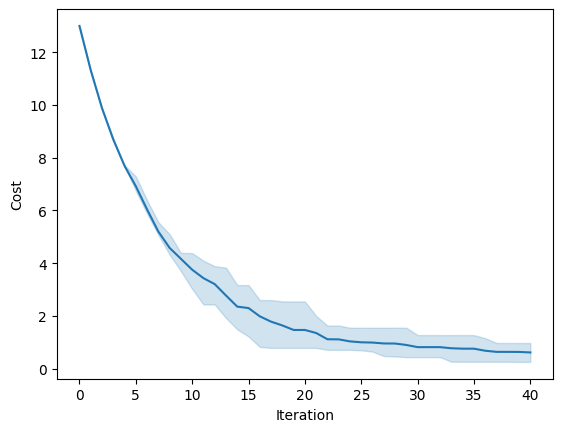

In [301]:
cost_stat = {}
cost_stat["mean"] = []
cost_stat['max'] = []
cost_stat['min'] = []

for iteration in range(n_i+1):
    iteration_data = [data[f"Cost Trial {i}"][iteration] for i in range(n_t)]

    mean_val = np.mean(iteration_data)
    max_val = np.max(iteration_data)
    min_val = np.min(iteration_data)

    cost_stat['mean'].append(mean_val)
    cost_stat['max'].append(max_val)
    cost_stat['min'].append(min_val)

plt.plot(data['index'],cost_stat['mean'])

plt.gca().fill_between(data['index'],cost_stat['min'],cost_stat['max'],color='C0', alpha=0.2)

plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

### II. Plant with uncertainty

In [302]:
n_s                 = 5                            # number of samples
n_t                 = 5                             # number of trials
n_i                 = 40                            # number of iterations
plant_fun           = Benoit_System_1
plant_con1          = con1_system_tight

data = {}
data['index']       = []
data['u_0']         = []
data['u_1']         = []
data['r']           = []
data['modifiers']   = []

# Algorithm
for i in range(n_t):
    # Initialization
    uk                  = [4,-1]
    theta_0             = [1,1,1,1]
    r                   = 0.2
    theta,modifierk,GP_m     = GP_Initilization(n_s,uk,theta_0,r,plant_fun,plant_con1)
    print(theta)

    # Dictionary for data collection at the last iter
    if i == (n_t-1):
        data['index']       = [0]
        data['u_0']         = [uk[0]]
        data['u_1']         = [uk[1]]
        data['r']           = [r]
        data['modifiers']   = [[modifierk]]

    # (k=0)
    funk = plant_fun(uk)
    fun_mk = Benoit_Model_nomodifier(uk,theta)
    cost    = [funk]

    for j in range(n_i):
        dk_1,fun_mk_1                           = cost_optimize_d_withGP(r,uk,theta,GP_m)                                            # Find optimal step and output from the model 
        uk_1                                    = uk + dk_1                                                                     # Find optimal input
        
        # Modifier 
        f_modifier                              = plant_fun(uk_1) - Benoit_Model_nomodifier(uk_1,theta)
        c_modifier                              = (plant_con1(uk_1) - con1_model_nomodifier(uk_1,theta))*(-1)
        modifierk_1                             = [f_modifier,c_modifier]
        GP_m.add_sample(uk_1,modifierk_1)
        
        # Update variables for next iteration
        uk = uk_1
        fun_mk = fun_mk_1
    
        # Data Collection
        ## New cost
        funk_1                                  = plant_fun(uk_1)
        cost.append(funk_1)

        # Data Collection for graphical illustration at the last iteration 
        if i == (n_t-1):
            data['index'].append(j+1)
            data['u_0'].append(uk_1[0])
            data['u_1'].append(uk_1[1])
            data['r'].append(r)
    
    data[f"Cost Trial {i}"] = cost

        
    print(f"optimal input: {uk}")

[0.74568333 0.71754253 1.94370241 2.0805708 ]
optimal input: [ 0.37144102 -0.3924638 ]
[0.76765723 1.22283893 1.47535914 1.1812875 ]
optimal input: [ 0.40000879 -0.37395742]
[0.73871903 0.74462668 1.94121567 2.06919523]
optimal input: [ 0.37972362 -0.3908081 ]
[0.74581225 0.73790604 1.79290384 2.08009604]
optimal input: [ 0.31330784 -0.44701016]
[0.73047745 0.69702842 1.98834529 2.06168968]
optimal input: [ 0.3502913  -0.40156006]


real optimal input: [ 0.36845785 -0.39299271]


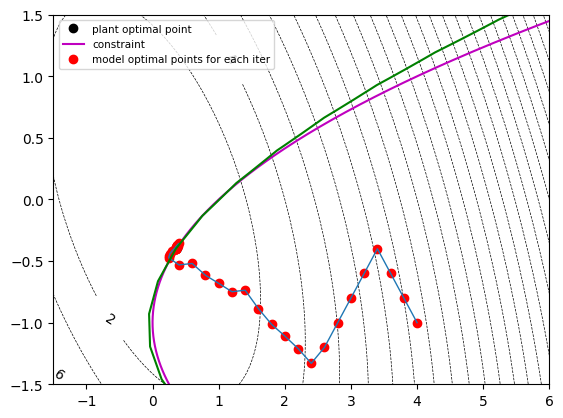

In [303]:
num_points = 100

plant_drawing(is_constraint=False,is_tight_constraint=True)

plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')

uc_0 = np.linspace(-6.5,6.5,50)
uc_1 = np.linspace(-6.5,6.5,50)
UC_0,UC_1 = np.meshgrid(uc_0,uc_1)
F_C = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        U = [UC_0[i][j],UC_1[i][j]]
        d = np.array([0,0])
        F_C[i][j] = con1_model_d_withGP(d,U,theta,GP_m)
plt.contour(UC_0,UC_1,F_C,[0],colors='g')

# i = 0
# for i in range(data['index'][-1]+1):
#     centerx,centery = data['u_0'][i],data['u_1'][i]
#     r = data['r'][i]

#     x = np.linspace(centerx-r, centerx+r, 50)
#     y = np.linspace(centery-r, centery+r, 50)
#     X, Y = np.meshgrid(x,y)
#     F = (X-centerx)**2 + (Y-centery)**2 - r**2
#     plt.contour(X,Y,F,[0],colors='b',linewidths = 0.3)

plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

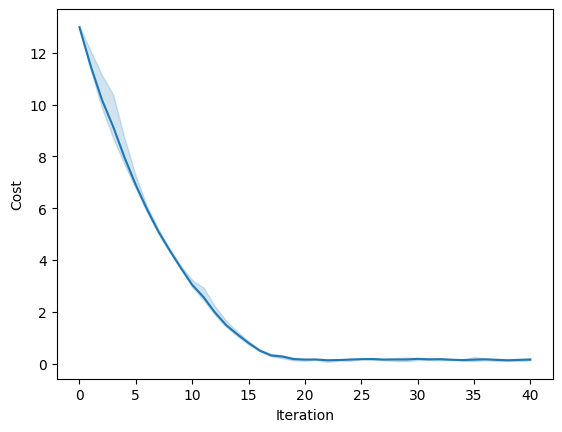

In [304]:
cost_stat = {}
cost_stat["mean"] = []
cost_stat['max'] = []
cost_stat['min'] = []

for iteration in range(n_i+1):
    iteration_data = [data[f"Cost Trial {i}"][iteration] for i in range(n_t)]

    mean_val = np.mean(iteration_data)
    max_val = np.max(iteration_data)
    min_val = np.min(iteration_data)

    cost_stat['mean'].append(mean_val)
    cost_stat['max'].append(max_val)
    cost_stat['min'].append(min_val)

plt.plot(data['index'],cost_stat['mean'])

plt.gca().fill_between(data['index'],cost_stat['min'],cost_stat['max'],color='C0', alpha=0.2)

plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()